In [1]:
# Use this to add the tag_tracking folder to python path for imports
import os, sys
tag_tracking_path = os.path.abspath(os.path.join('', './../..'))
sys.path.insert(0, tag_tracking_path)

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_track.network_resnet2 import ResNet2
from tagsim.utils import get_patch_path

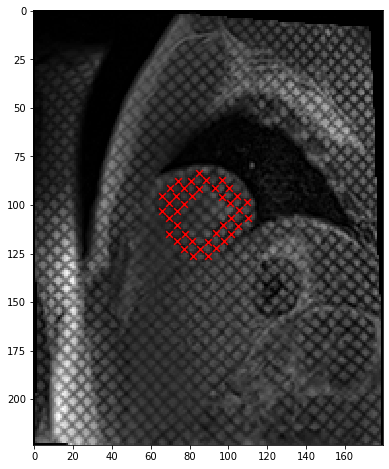

In [30]:
# Load the sample dataset
npz = np.load('../sample_data/in_vivo_data.npz')
imt = npz['imt']
r0 = npz['r0']

# Plot the points we are tracking
plt.figure(figsize=(8,8))
plt.imshow(imt[0], cmap='gray')
plt.scatter(r0[:,0], r0[:,1], 45, c='r', marker='x')

In [5]:
# Get patches for each point in r0

N = r0.shape[0]
X = np.empty((N, 1, 25, 32, 32), np.float32)

for i in range(N):
    track_init = r0[i]
    im_p, tag_p = get_patch_path(imt, track_init, is_scaled = True)
    X[i] = im_p.copy()
    
# Normalize patches
for i in range(X.shape[0]):
    im = X[i]
    im = (im-im.mean()) / im.std()
    X[i] = im

In [4]:
# Load the model
# ----------------

# device = torch.device("cuda:0") # For GPU inference
device = torch.device("cpu") # For CPU inference

state_name = '../network_saves/resnet2_grid_tracking.pt'

kwargs = {}
kwargs['do_coordconv'] = True
kwargs['fc_shortcut'] = False
# kwargs['init_width'] = 128

model = ResNet2([2, 2, 2, 2], **kwargs)

# state = torch.load('./resnet2_18_big_k2_batch16_bestref.pt', map_location='cpu')
state = torch.load(state_name, map_location=device)

model.load_state_dict(state)

model = model.to(device)

In [12]:
batch_size = 8

y1 = []
N = X.shape[0]
N_batches = int(np.ceil(N / batch_size))

print('Training: batch = ', end = '', flush = True)
with torch.no_grad():  
    for i in range(N_batches):
        print(i, end = ' ', flush=True)
        x = X[i*batch_size:(i+1)*batch_size]
        x = torch.from_numpy(x).to(device)
        y_pred = model(x)
        y1.append(y_pred.detach().cpu().numpy())

y1 = np.vstack(y1)
y1 = y1.reshape([y1.shape[0], 2, 25])
print('Done!')

# y1 is the paths relative to the center of the patches, add r0 to get in image coords
y1r = y1 + r0[:,:,None]

Training: batch = 0 1 2 3 4 5 Done!


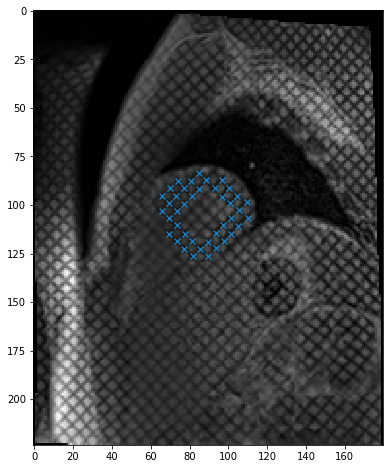

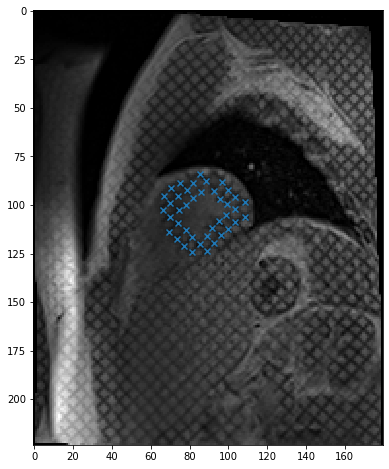

In [18]:
# Plot the points at time 0 and 12
i_t = 0
plt.figure(figsize=(8,8))
plt.imshow(imt[i_t], cmap='gray')
plt.scatter(y1r[:,0,i_t], y1r[:,1,i_t], 45, c='r', marker='x')

i_t = 12
plt.figure(figsize=(8,8))
plt.imshow(imt[i_t], cmap='gray')
plt.scatter(y1r[:,0,i_t], y1r[:,1,i_t], 45, c='r', marker='x')

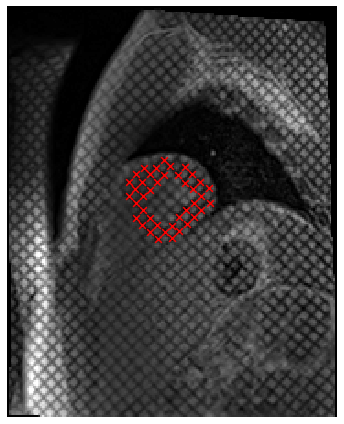

In [34]:
tag = '04_final'
save_folder = '../../tagsim/scmr_temp/anims/{}/'.format(tag)
os.makedirs(save_folder, exist_ok = True)

for i_t in range(imt.shape[0]):

    fig = plt.figure(figsize=[6,6])
    ax = fig.add_subplot(111)

    plt.imshow(imt[i_t], cmap='gray', clim = [0, 0.9*imt.max()])
    plt.scatter(y1r[:,0,i_t], y1r[:,1,i_t], 45, c='r', marker='x')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    plt.tight_layout()

    plt.savefig('{}/frame_{:03d}.png'.format(save_folder, i_t), dpi=200, bbox_inches='tight', pad_inches=0)
    if i_t == 0:
        plt.show()
    else:
        plt.close()

In [35]:
gifs_path = os.path.abspath(os.path.join('', './../../tagsim/scmr_temp/'))
sys.path.insert(0, gifs_path)

from save_gifs import save_gif, save_gif_windows
p0 = save_gif_windows(save_folder, save_folder = '../../tagsim/scmr_temp/anims/', save_name = '{}.gif'.format(tag), ww=256, framerate = 16)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '../../tagsim/scmr_temp/anims/04_final/aa_out.gif'

In [ ]:
im_p, tag_p = get_patch_path(imt, r0)